In [14]:
import pandas as pd
from pyarrow import feather
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import umap

In [2]:
%%time
d = feather.read_feather("census_features_2019_county.feather")
print(d.shape)
d.head()

(87043040, 3)
CPU times: total: 12 s
Wall time: 10.5 s


,value,unique_id,variable
0,20245.0,17051,B01001A_001E
1,25667.0,17107,B01001A_001E
2,22234.0,17165,B01001A_001E
3,531609.0,17097,B01001A_001E
4,12956.0,17127,B01001A_001E


In [3]:
# ex = acs_vars.loc[acs_vars["Predicate Type"].isin(["int", "float"])] #figure out how to filter down vars

In [4]:
acs_vars = pd.read_csv("acs_vars.csv")
states =  pd.read_csv("geo_codes/state-geocodes.csv")
states.columns = [c.lower().replace(" ", "_").replace(r"(fips)", "fips") for c in states.columns]
for col in states.columns: states[col] = states[col].astype(str)

In [5]:
def parse_fips(f):
    f = str(f)
    if len(f) < 2:
        return "0"+f
    return f
states.state_fips = states.state_fips.apply(parse_fips)
states.drop("name", axis=1, inplace=True)

In [6]:
counties = pd.read_csv("geo_codes/county_fips_codes.csv", dtype=str)
counties["fips"] = counties.state_fips + counties.county_fips
counties = counties.merge(states, how="left", on="state_fips")

In [7]:
counties

,state_name,county_name,state_fips,county_fips,fips,region,division
0,Alabama,Autauga,01,001,01001,3,6
1,Alabama,Baldwin,01,003,01003,3,6
2,Alabama,Barbour,01,005,01005,3,6
3,Alabama,Bibb,01,007,01007,3,6
4,Alabama,Blount,01,009,01009,3,6
...,...,...,...,...,...,...,...
3137,Wyoming,Sweetwater,56,037,56037,4,8
3138,Wyoming,Teton,56,039,56039,4,8
3139,Wyoming,Uinta,56,041,56041,4,8
3140,Wyoming,Washakie,56,043,56043,4,8


In [8]:
fips_ids = d.unique_id.unique()
n_counties = len(fips_ids)
tot_n_variables  = d.variable.nunique()

print(n_counties, tot_n_variables)

3220 27032


In [9]:
%%time
# deal with missing values
## simple: get rid of any variable which is not complete for all counties

var_groups = d.groupby("variable")
complete_vars = []
for name, var in var_groups:
    var.dropna(axis=0, inplace=True)
    if var.shape[0] != n_counties:
        continue
    complete_vars.append(name)

CPU times: total: 46.9 s
Wall time: 51 s


In [10]:
print(f"N variables with values for all counties:", len(complete_vars))

N variables with values for all counties: 15910


In [11]:
d_complete = d.loc[d.variable.isin(complete_vars), :].reset_index(drop=True)
n_variables = d_complete.variable.nunique()

In [12]:
%%time
# Build feature vectors per-fips
fips_groups = d_complete.groupby("unique_id")
feature_array = np.zeros((len(fips_ids), n_variables), dtype=np.float32)

for i, (name, group) in enumerate(fips_groups):
    feature_array[i,:] = group["value"].values

CPU times: total: 15.5 s
Wall time: 15.6 s


In [13]:
# Scale features and do PCA
features_scaled = StandardScaler().fit_transform(feature_array)
features_pca = PCA(n_components=15).fit_transform(features_scaled)

Notes: 
- Papers (for example https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1008432) say that its common (at least in genetics) to apply PCA to the dataset to reducde dimensions prior to running it through UMAP.  
- In the LOAM-viz code, the guy does something similair by using cuml.GaussianRandomProjection with 64 components to reduce dims [fork: https://github.com/hans-elliott99/loam-viz].  
- The visualization is interesting regardless.  


Cool introduction to UMAP: https://pair-code.github.io/understanding-umap/  


In [36]:
%%time
# api: https://umap-learn.readthedocs.io/en/latest/api.html
reducer = umap.UMAP(
    n_neighbors=15,         #default: 15
    n_components=2,  
    min_dist=0.1,            #default: 0.1
    negative_sample_rate=20, #default: 5
    n_epochs=1000,
    verbose=True,
    random_state=431
)
x = reducer.fit_transform(features_pca)

UMAP(n_epochs=1000, negative_sample_rate=20, random_state=431, verbose=True)
Wed Feb  8 15:19:20 2023 Construct fuzzy simplicial set
Wed Feb  8 15:19:24 2023 Finding Nearest Neighbors
Wed Feb  8 15:19:24 2023 Finished Nearest Neighbor Search
Wed Feb  8 15:19:24 2023 Construct embedding


Epochs completed: 100%| ██████████ 1000/1000 [00:28]

Wed Feb  8 15:19:52 2023 Finished embedding
CPU times: total: 33.5 s
Wall time: 32.2 s


In [37]:
plot_df = pd.DataFrame({"fips" : fips_ids})
plot_df["x"] = x[:, 0]
plot_df["y"] = x[:, 1]
plot_df["state"] = plot_df.fips.str.slice(0, 2)
plot_df = plot_df.merge(counties, how="left", on="fips")

In [38]:
plot_df["region_name"] = plot_df.region.map({"1" : "Northeast", "2" : "Midwest", "3" : "South", "4" : "West"})
plot_df["annotation"]  = plot_df.county_name +", "+ plot_df.state_name

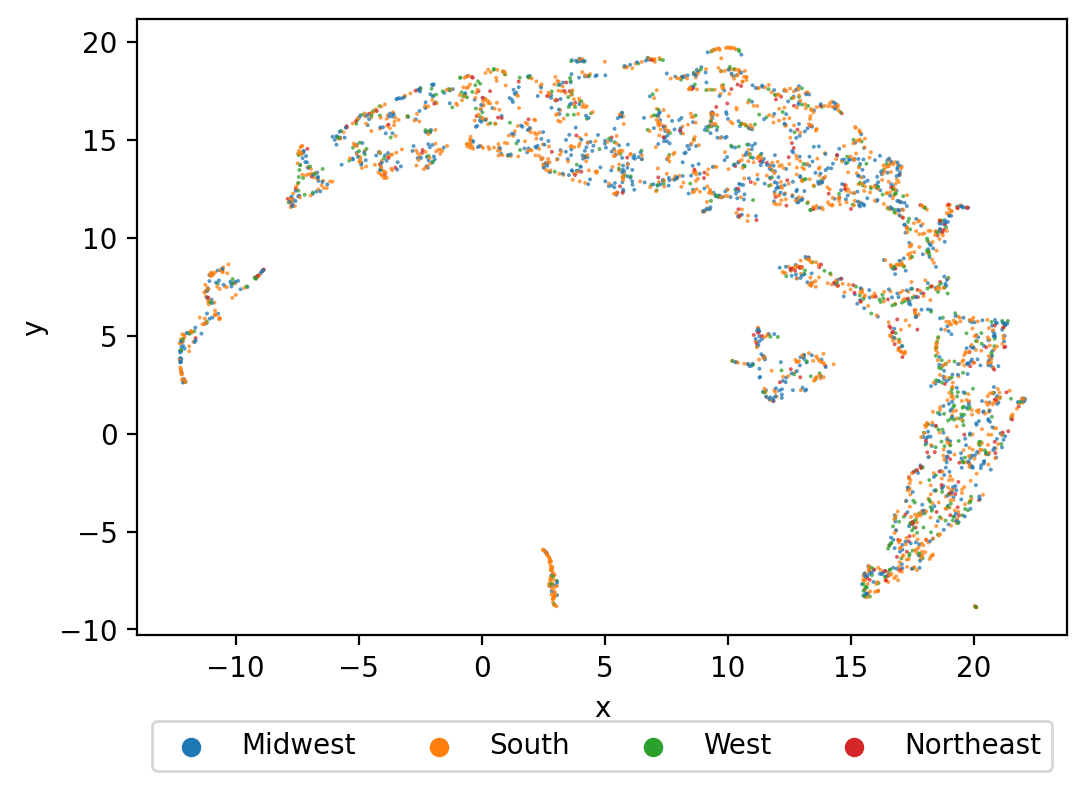

In [57]:
color_by = "region_name"
legend_cols = 4
legend_ypos = -.22

plt.figure(figsize=(6,4), dpi=200)

ax = sns.scatterplot(
    x='x',
    y='y',
    s=2,
    linewidth=0,
    alpha=0.75,
    hue=color_by,
    palette='tab10',
    legend=True,
    data=plot_df,
)
plt.legend(loc="lower center", 
           ncol=legend_cols, 
           borderaxespad=0,
           bbox_to_anchor=(0.5, legend_ypos)
           )

# labels = set()
# for i, txt in enumerate(plot_df["state_name"]):
#     if txt in labels: 
#         continue
#     labels.update([txt])
#     plt.annotate(text=txt, 
#                  xy=(x[i, 0], x[i, 1]), 
#                  alpha = 0.2,
#                  size=5
#                 )

plt.show()